In [1]:
include("inverse_prob.jl")
using PyPlot, JLD2, DSP

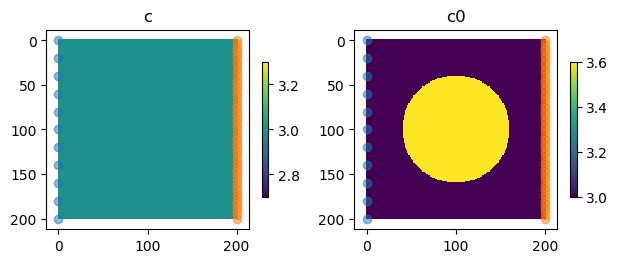

In [2]:
Nx = 201;
Ny = 201;
h = 0.01;
x = range(0,step=h,length=Nx)
y = range(0,step=h,length=Ny)

Fs = 1000;
dt = 1/Fs
Nt = 1200;
t = range(0, length=Nt, step=dt)
t0 = range(0, length=2000, step=dt)

source = source_ricker(10, 0.15, t0)
responsetype = Highpass(3; fs=Fs)
designmethod = FIRWindow(hanning(1024-1))
ss = filt(digitalfilter(responsetype, designmethod), -source);
source = ss[512:512+1200-1]
source = source./ maximum(source)

source_position = zeros(11,2)
for i = 1:11
    source_position[i,:] = [20*(i-1)+1, 1]
#         source_position[i,:] = [1 101]
end
source = repeat(source, 1, 11)

receiver_position = zeros(51,2)
for i = 1:51
    receiver_position[i,:] = [(i-1)*4+1, 201]
end

c0 = 3*ones(Nx, Ny)
rho0 = ones(Nx, Ny)
for i = 1:Nx
    for j = 1:Ny
        if sqrt((x[i]-1).^2 + (y[j]-1).^2) < 0.6
            c0[i,j] = 3.6
        end
    end
end
#     c0[50:end,:] .= 1.2

c = 3*ones(Nx, Ny)
#     c[1:end,:] = imfilter(c0[1:end,:], Kernel.gaussian(10));
rho = ones(Nx, Ny);

figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c"); 
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0"); 
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
tight_layout()

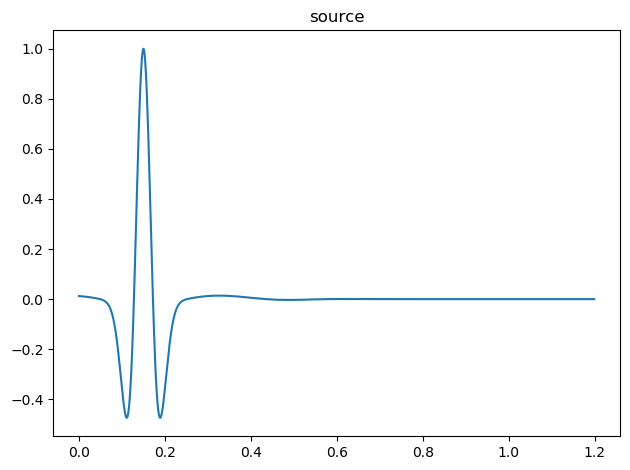

In [3]:
plot(t,source[:,1]); title("source"); tight_layout()

In [4]:
save_ratio = 12;
pml_len = 30;
pml_coef = 100;

@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef, save_ratio=save_ratio);
@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef, save_ratio=save_ratio);


 95.612360 seconds (20.34 M allocations: 620.580 GiB, 14.48% gc time)
 89.341251 seconds (2.85 M allocations: 619.777 GiB, 13.96% gc time)


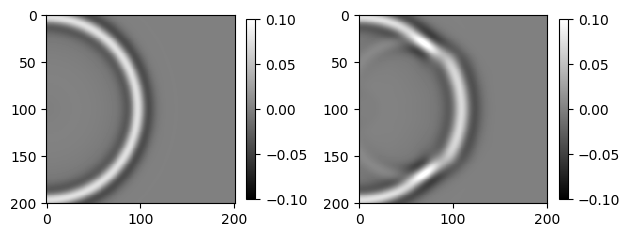

In [5]:
figure;
time_ind = 40
subplot(121); imshow(u[:,:,time_ind,6],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122); imshow(u0[:,:,time_ind,6],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

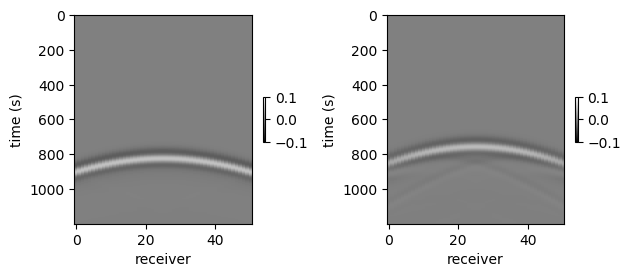

In [6]:
figure;
subplot(121); imshow(data[:,:,6],cmap=ColorMap("gray"), aspect=0.05); colorbar(shrink=0.1); clim([-0.1,0.1])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,6],cmap=ColorMap("gray"), aspect=0.05); colorbar(shrink=0.1); clim([-0.1,0.1])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

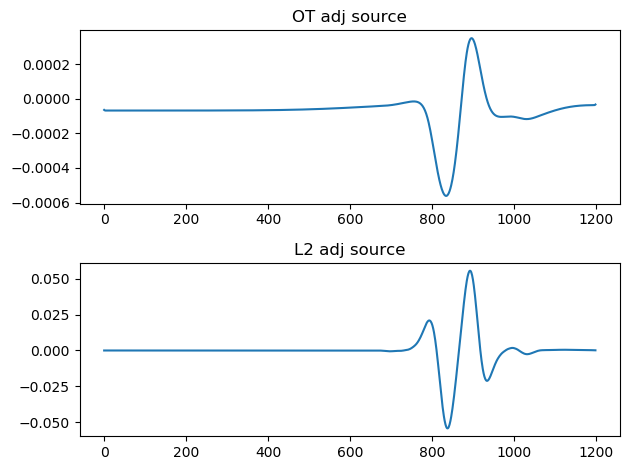

In [7]:
M = cost_matrix_1d(t,t; p=2)
reg = 1e-5
reg_m = 1e0
reg_p = 0.1
iterMax = 3000;

f = data[:,30,2] .+ reg_p
g = data0[:,30,2] .+ reg_p

TT,gg,dd = unbalanced_sinkhorn_1d(f, g, M, reg, reg_m; iterMax=iterMax);
subplot(211); plot(gg); title("OT adj source")
subplot(212); plot(f-g); title("L2 adj source")
tight_layout()

# Save data

In [10]:
@save "camembert_data/camembert_mode.jld2" c c0 rho Nx Ny Nt h t dt source source_position receiver_position save_ratio pml_len pml_coef

In [9]:
@save "camembert_data/camembert_data.jld2" data data0